In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('movie_review_fullsentence.csv')

In [3]:
#!pip install transformers

In [4]:
from transformers import BertTokenizer
import tensorflow as tf
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=512,
                                   pad_to_max_length=True,
                                   add_special_tokens=True,
                                   return_token_type_ids=False,
                                   return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [5]:
import numpy as np
Xids = np.zeros((len(df), 512))
Xmask = np.zeros((len(df), 512))
for i, sequence in enumerate(df['Phrase']):
    tokens = tokenize(sequence)
    Xids[i, :], Xmask[i, :] = tokens[0], tokens[1]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
2021-12-21 08:00:15.111386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful N

In [6]:
arr = df['Sentiment'].values
labels = np.zeros((arr.size, arr.max()+1))
labels[np.arange(arr.size), arr] = 1
labels

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]])

In [7]:
data = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
SHUFFLE = 100000
BATCH_SIZE = 16
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

data = data.map(map_func)
data = data.shuffle(SHUFFLE).batch(BATCH_SIZE) #, drop_remainder=True)

SIZE = Xids.shape[0]/BATCH_SIZE
SIZE

SPLIT = 0.7
train = data.take(int(SIZE*SPLIT))
val = data.skip(int(SIZE*SPLIT))

In [8]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')
bert.summary()


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [9]:
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  


x = tf.keras.layers.Dropout(0.1)(embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 512, 768)     0           bert[0][0]                   

In [10]:
import visualkeras
visualkeras.layered_view(model, legend=True,to_file='transfer.png')

RuntimeError: not supported tensor shape TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=(None, 512, 768), pooler_output=(None, 768), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, )
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [12]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20)

Epoch 1/20


2021-12-21 08:02:29.379176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


373/373 [==============================] - 368s 963ms/step - loss: 2.1090 - accuracy: 0.3071 - val_loss: 1.6738 - val_accuracy: 0.4197
Epoch 2/20
373/373 [==============================] - 365s 980ms/step - loss: 1.9103 - accuracy: 0.3356 - val_loss: 1.7479 - val_accuracy: 0.2855
Epoch 3/20
373/373 [==============================] - 365s 980ms/step - loss: 1.7674 - accuracy: 0.3725 - val_loss: 1.5694 - val_accuracy: 0.3420
Epoch 4/20
373/373 [==============================] - 365s 979ms/step - loss: 1.8619 - accuracy: 0.3701 - val_loss: 1.8328 - val_accuracy: 0.3756
Epoch 5/20
373/373 [==============================] - 365s 979ms/step - loss: 1.7926 - accuracy: 0.3819 - val_loss: 1.3573 - val_accuracy: 0.4403
Epoch 6/20
373/373 [==============================] - 365s 979ms/step - loss: 1.7872 - accuracy: 0.3830 - val_loss: 1.6910 - val_accuracy: 0.3518
Epoch 7/20
373/373 [==============================] - 365s 979ms/step - loss: 1.7646 - accuracy: 0.3832 - val_loss: 1.3102 - val_accura

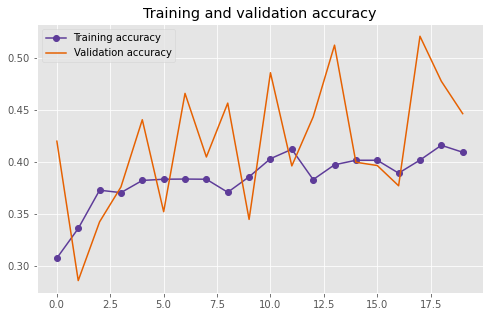

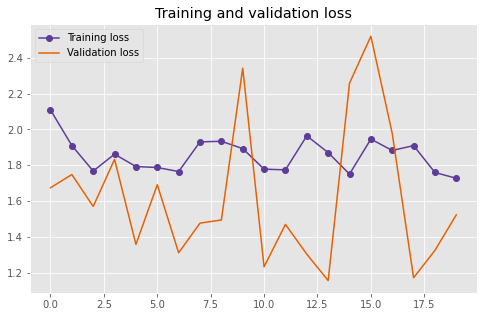

In [13]:
import matplotlib.pyplot as plt
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
plot_train_curve(history)

In [14]:
loss, acc = model.evaluate(val)

161/161 [==============================] - 99s 613ms/step - loss: 1.5143 - accuracy: 0.4555


In [24]:
# get predictions
predections=np.argmax(model.predict(val))

# # compute confusion matrix with `tf` 
# confusion = tf.math.confusion_matrix(
#               labels = np.argmax(y_train, axis=1),      # get trule labels 
#               predictions = np.argmax(y_pred, axis=1),  # get predicted labels 
#               num_classes=num_of_classess)   

AxisError: axis 1 is out of bounds for array of dimension 1

In [42]:
predicted=np.argmax(predections,axis=1)

In [41]:
y_test=[item[1] for item in val]
y_test=[sub_item for item in y_test for sub_item in item]
len(y_test)
test_labels = np.argmax(y_test,axis=1)

[[  6 181   0  48  88]
 [  2 409   1  89 158]
 [  2 275   2  87 114]
 [ 10 433   2 106 167]
 [  2 245   2  58  77]]
              precision    recall  f1-score   support

           0       0.27      0.02      0.03       323
           1       0.27      0.62      0.37       659
           2       0.29      0.00      0.01       480
           3       0.27      0.15      0.19       718
           4       0.13      0.20      0.16       384

    accuracy                           0.23      2564
   macro avg       0.24      0.20      0.15      2564
weighted avg       0.25      0.23      0.18      2564



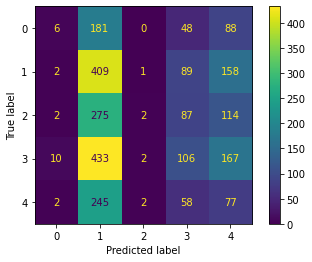

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cnf_matrix = confusion_matrix(test_labels, predicted)
print(cnf_matrix)
cf_report = classification_report(test_labels, predicted)
print(cf_report)

# plot_confusion_matrix(cnf_matrix,X_test,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()